<a href="https://colab.research.google.com/github/tarun-bandi/ml_notes/blob/main/lenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torchinfo

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
from torch import nn
from torchvision import datasets, transforms
from torchinfo import summary
from tqdm import tqdm
import torch.optim as optim



Let's download the MNIST dataset

In [3]:
MEAN, STD = 0.1307, 0.3081
transformation = transforms.Compose([transforms.Pad(2), transforms.ToTensor(), transforms.Normalize((MEAN,), (STD, ))])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


trainingData = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transformation
)

testingData = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=transformation
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.3MB/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 493kB/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.58MB/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.18MB/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



First let's visualize the images

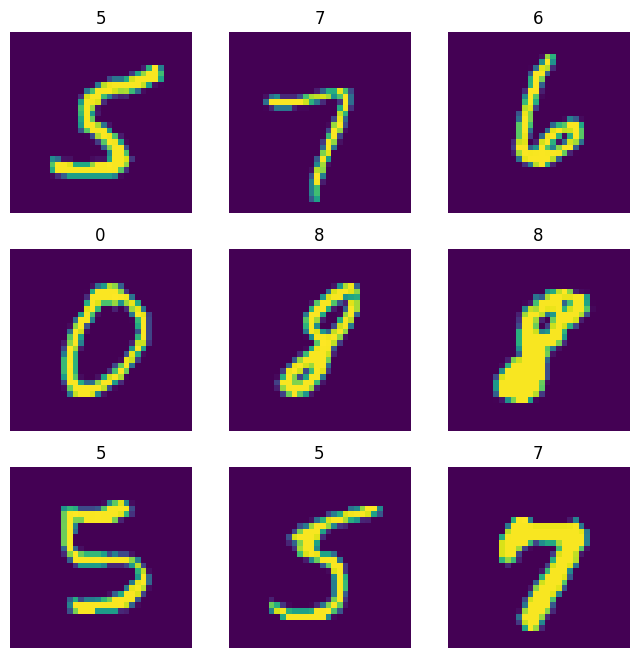

torch.Size([1, 32, 32])


In [4]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
  sample_idx = torch.randint(len(trainingData), size=(1,)).item()
  img, label = trainingData[sample_idx]
  figure.add_subplot(rows, cols, i)
  plt.title(f"{label}")
  plt.axis("off")
  plt.imshow(img.squeeze())
plt.show()
print(trainingData[0][0].shape)

The shape is 32x32, perfect for the LeNet.


---


We will define dataloaders for both training and test



In [5]:
train_loader = DataLoader(trainingData,
                        batch_size=32)
test_loader = DataLoader(testingData,
                         batch_size=32)


Now we define the different parts of the architecture.

The first Convolutional layer consists of 6 different filters, with 5x5 filters, no padding, and a stride of 1

Then we have a downsampling pooling layer w/ 2x2 kernels and a stride of 2

Then another conv layer with 16 filters 5x5 kernels

Then a max pooling later with 2x2 kernels and a stride of 2

then 3 fully connected layers 120 -> 84 -> 10

finally, a softmax along dim 0


In [6]:
class ConvNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv_1 = nn.Conv2d(in_channels=1,
                            out_channels=6,
                            kernel_size=5) #Stride = 1
    self.maxpool_1 = nn.MaxPool2d(kernel_size=2,
                                  stride=2)
    self.conv_2 = nn.Conv2d(in_channels=6,
                            out_channels=16,
                            kernel_size=5)
    self.maxpool_2 = nn.MaxPool2d(kernel_size=2,
                                  stride=2)
    self.fullyconnected1 = nn.Linear(400, 120)
    self.fullyconnected2 = nn.Linear(120, 84)
    self.finalConnected = nn.Linear(84, 10)
  def forward(self, x):
    downsampled_convolved = self.maxpool_2(self.conv_2(self.maxpool_1(self.conv_1(x))))
    reshaped = torch.reshape(downsampled_convolved, (downsampled_convolved.size(0), -1))
    return self.finalConnected(self.fullyconnected2(self.fullyconnected1(reshaped)))
model = ConvNet()
summary(model, input_size=(32, 1, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
ConvNet                                  [32, 10]                  --
├─Conv2d: 1-1                            [32, 6, 28, 28]           156
├─MaxPool2d: 1-2                         [32, 6, 14, 14]           --
├─Conv2d: 1-3                            [32, 16, 10, 10]          2,416
├─MaxPool2d: 1-4                         [32, 16, 5, 5]            --
├─Linear: 1-5                            [32, 120]                 48,120
├─Linear: 1-6                            [32, 84]                  10,164
├─Linear: 1-7                            [32, 10]                  850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
Total mult-adds (M): 13.54
Input size (MB): 0.13
Forward/backward pass size (MB): 1.67
Params size (MB): 0.25
Estimated Total Size (MB): 2.05

In [10]:
num_epochs = 10
curr_loss = 0

conv_net = ConvNet().to(device)
optimizer = optim.Adam(conv_net.parameters())
criterion = nn.CrossEntropyLoss().to(device)

for epoch in range(num_epochs):

  progress_bar = tqdm(train_loader,
                      desc=f"Epoch {epoch + 1}/{num_epochs}",
                        leave=True,
                       position=0,
                       ncols=80)
  conv_net.train()
  incorrect_examples = 0
  total_examples = 0
  running_loss = 0.0

  for batch_idx, (image, label) in enumerate(progress_bar):
    image = image.to(device)
    label = label.to(device)

    guess = conv_net(image)
    loss = criterion(guess, label)



    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    _, predicted = torch.max(guess, dim=1)
    incorrect_examples += (label != predicted).sum().item()
    total_examples += label.size(0)

    running_loss += loss.item()
    avg_loss = running_loss / (batch_idx + 1)

    accuracy = 100 * (1 - incorrect_examples / total_examples)
    progress_bar.set_postfix({
        'loss': f'{avg_loss:.4f}',
        'acc': f'{accuracy:.2f}%'
    }, refresh=True)

  progress_bar.close()


Epoch 10/10: 100%|█| 1875/1875 [00:28<00:00, 66.51it/s, loss=0.0425, acc=98.65%]


In [11]:
  conv_net.eval()
  progress_bar = tqdm(test_loader)
  incorrect_examples = total_examples = 0
  with torch.no_grad():
    for image, label in progress_bar:
      image = image.to(device)
      label = label.to(device)

      guess = conv_net(image)
      _, predicted = torch.max(guess, dim=1)

      incorrect_examples += (label != predicted).sum().item()
      total_examples += label.size(0)

      accuracy = 100 * (1 - incorrect_examples / total_examples)
      progress_bar.set_postfix({
                  'acc': f'{accuracy:.2f}%'
              })


    print(incorrect_examples/len(test_loader))
progress_bar.close()
print(f"Test Accuracy: {100 * (1 - incorrect_examples/total_examples):.2f}%")

100%|██████████| 313/313 [00:04<00:00, 67.67it/s, acc=97.71%]

0.731629392971246
Test Accuracy: 97.71%
